In [11]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.medical_imaging import get_chexpert
from source.utils.metrics import auroc, aod, eod, spd

os.makedirs(PLOTS_PATH, exist_ok=True)

In [12]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

models = ["resnet18", "resnet34", "resnet50"]

pas = ["age", "gender", "race"]
pa = 0 # 0, 1, 2

In [13]:
full_ds, _, _ = get_chexpert(load_to_ram=False)

run_path = os.path.join(RESULTS_PATH, f"chexpert_{models[0]}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds))

y_fair_t = full_ds.targets[fair_inds]
a_fair_t = full_ds.protected_attributes[pa, fair_inds]
y_val_t = full_ds.targets[val_inds]
a_val_t = full_ds.protected_attributes[pa, val_inds]

# switch 0 / 1 in protected attribute
pas = ["young", "man", "non-white"]
a_fair_t = 1 - a_fair_t
a_val_t = 1 - a_val_t

# patients general 65401
# patients with race 58010
24638 24638


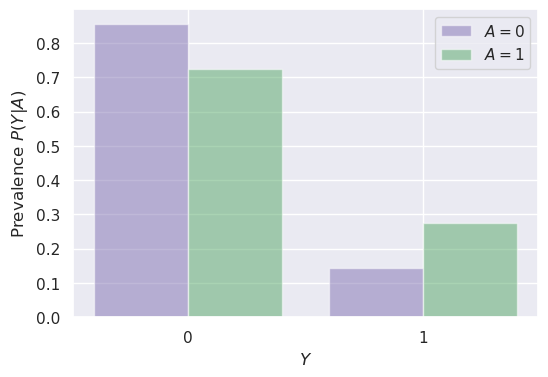

In [14]:
# plot p(Y | A) for testset
p_y1_a0 = y_fair_t[a_fair_t == 0].float().mean().item()
p_y1_a1 = y_fair_t[a_fair_t == 1].float().mean().item()
p_y0_a0 = 1 - p_y1_a0
p_y0_a1 = 1 - p_y1_a1

# barplot
plt.figure(figsize=(6, 4))
plt.bar([-0.2, 0.8], [p_y0_a0, p_y1_a0], color="C4", width=0.4, alpha=0.5, label='$A=0$')
plt.bar([0.2, 1.2], [p_y0_a1, p_y1_a1], color="C2", width=0.4, alpha=0.5, label='$A=1$')
plt.xlabel('$Y$')
plt.ylabel('Prevalence $P(Y | A)$')
plt.xticks([0, 1])
plt.legend()
plt.show()

In [15]:
# load probits
fair_probits = list()

for model in models:
    for mseed in method_seeds:
        path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{mseed}_dseed{dseed}")

        fair_probits.append(torch.load(os.path.join(path, f"fair_probits.pt")))
    
fair_probits = torch.stack(fair_probits).reshape(len(models), len(method_seeds), fair_probits[0].shape[0], -1, 2)

print(fair_probits.shape)

torch.Size([3, 5, 10, 24638, 2])


In [16]:
fair_m_accs = list()
fair_m_spds = list()
fair_m_eods = list()
fair_m_aods = list()

for m in range(len(models)):
    for s in range(len(method_seeds)):

        fair_m_accs.append(auroc(torch.mean(fair_probits[m, s], dim=0)[:, 1], y_fair_t) \
                                - torch.mean(torch.tensor([auroc(fp[:, 1], y_fair_t) for fp in fair_probits[m, s]])))

        fair_m_spds.append(spd(torch.mean(fair_probits[m, s], dim=0).argmax(dim=1), a_fair_t) \
                              - torch.mean(torch.tensor([spd(fp.argmax(dim=1), a_fair_t) for fp in fair_probits[m, s]])))
        
        fair_m_eods.append(eod(torch.mean(fair_probits[m, s], dim=0).argmax(dim=1), y_fair_t, a_fair_t) \
                                - torch.mean(torch.tensor([eod(fp.argmax(dim=1), y_fair_t, a_fair_t) for fp in fair_probits[m, s]])))
        
        fair_m_aods.append(aod(torch.mean(fair_probits[m, s], dim=0).argmax(dim=1), y_fair_t, a_fair_t) \
                                - torch.mean(torch.tensor([aod(fp.argmax(dim=1), y_fair_t, a_fair_t) for fp in fair_probits[m, s]])))

# reshape to (models, seeds)
fair_m_accs = torch.stack(fair_m_accs).reshape(len(models), len(method_seeds))
fair_m_spds = torch.stack(fair_m_spds).reshape(len(models), len(method_seeds))
fair_m_eods = torch.stack(fair_m_eods).reshape(len(models), len(method_seeds))
fair_m_aods = torch.stack(fair_m_aods).reshape(len(models), len(method_seeds))

print(fair_m_spds.shape, fair_m_spds.shape)

torch.Size([3, 5]) torch.Size([3, 5])


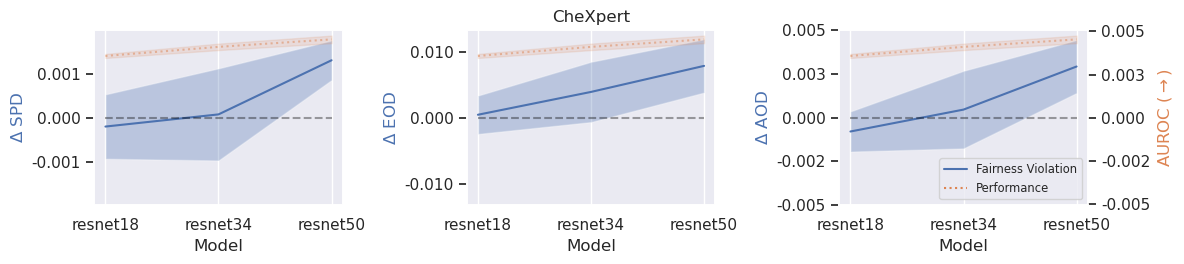

In [17]:
x = list(range(len(models)))
color = "C0"

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 2.8))

axs[0].plot(x, torch.mean(fair_m_spds, dim=1), "-")
axs[0].fill_between(x, 
                       torch.mean(fair_m_spds, dim=1) - torch.std(fair_m_spds, dim=1), 
                       torch.mean(fair_m_spds, dim=1) + torch.std(fair_m_spds, dim=1), alpha=0.3)
axs[0].set_ylabel("$\Delta$ SPD", color=color)
acc_axs.append(axs[0].twinx())
axs[1].plot(x, torch.mean(fair_m_eods, dim=1), "-")
axs[1].fill_between(x, 
                       torch.mean(fair_m_eods, dim=1) - torch.std(fair_m_eods, dim=1), 
                       torch.mean(fair_m_eods, dim=1) + torch.std(fair_m_eods, dim=1), alpha=0.3)
axs[1].set_ylabel("$\Delta$ EOD", color=color)
acc_axs.append(axs[1].twinx())
axs[2].plot(x, torch.mean(fair_m_aods, dim=1), "-")
axs[2].fill_between(x, 
                       torch.mean(fair_m_aods, dim=1) - torch.std(fair_m_aods, dim=1), 
                       torch.mean(fair_m_aods, dim=1) + torch.std(fair_m_aods, dim=1), alpha=0.3)
axs[2].set_ylabel("$\Delta$ AOD", color=color)
acc_axs.append(axs[2].twinx())

axs[1].set_title(f"CheXpert")

for ax in acc_axs:
    ax.plot(x, torch.mean(fair_m_accs, dim=1), ":", c="C1", alpha=0.5)
    ax.fill_between(x, 
                    torch.mean(fair_m_accs, dim=1) - torch.std(fair_m_accs, dim=1), 
                    torch.mean(fair_m_accs, dim=1) + torch.std(fair_m_accs, dim=1), alpha=0.15, color="C1")

handle_1 = mlines.Line2D([], [], color='C0', linestyle="solid", label='Fairness Violation')
handle_2 = mlines.Line2D([], [], color='C1', linestyle="dotted", label='Performance')
axs[2].legend(handles=[handle_1, handle_2], loc="lower right", fontsize="x-small")

plot_negative = False
for constraint in (fair_m_spds, fair_m_eods, fair_m_aods):
    if torch.mean(constraint) - torch.std(constraint) < 0:
        plot_negative = True
        break

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xticks(x)
    ax.set_xlabel("Model")
    ax.set_xticklabels(models)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

    y_lims = ax.get_ylim()
    y_lim = max(abs(y_lims[0]), abs(y_lims[1]))
    if plot_negative:
        ax.set_ylim(-y_lim * (1 + ax.margins()[0]), y_lim * (1 + ax.margins()[1]))
        ax.hlines(0, 0, len(models) - 1, colors="black", linestyles="--", alpha=0.2)
    else:
        ax.set_ylim(0, y_lim * (1 + ax.margins()[1]))

for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("AUROC ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])
    
    y_lims = ax.get_ylim()
    y_lim = max(abs(y_lims[0]), abs(y_lims[1]))
    if plot_negative:
        ax.set_ylim(-y_lim * (1 + ax.margins()[0]), y_lim * (1 + ax.margins()[1]))
        ax.hlines(0, 0, len(models) - 1, colors="black", linestyles="--", alpha=0.2)
    else:
        ax.set_ylim(0, y_lim * (1 + ax.margins()[1]))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"compare_models_chexpert_pa{pa}.pdf"))
plt.show()

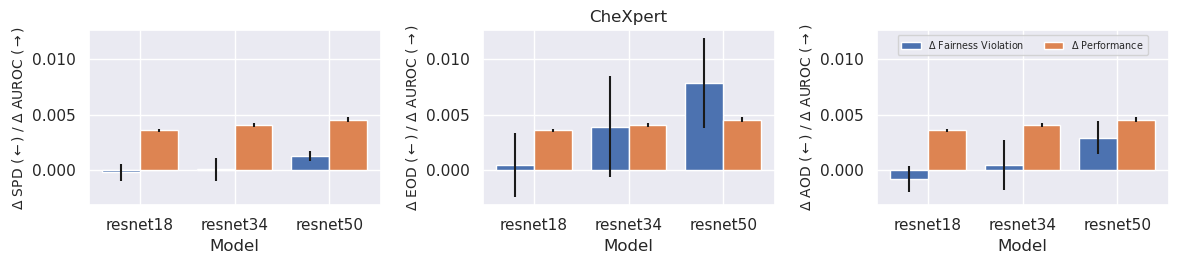

In [18]:
x = [_x - 0.2 for _x in range(len(models))]
xacc = [_x + 0.2 for _x in range(len(models))]
color = "C0"

acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 2.8), sharex=True)

axs[0].bar(x, torch.mean(fair_m_spds, dim=1), yerr=torch.std(fair_m_spds, dim=1), color=color, width=0.4, label="$\Delta$ Fairness Violation")
axs[0].set_ylabel("$\Delta$ SPD ($\leftarrow$) / $\Delta$ AUROC ($\\rightarrow$)", fontsize="small")
# acc_axs.append(axs[0].twinx())
axs[1].bar(x, torch.mean(fair_m_eods, dim=1), yerr=torch.std(fair_m_eods, dim=1), color=color, width=0.4, label="$\Delta$ Fairness Violation")
axs[1].set_ylabel("$\Delta$ EOD ($\leftarrow$) / $\Delta$ AUROC ($\\rightarrow$)", fontsize="small")
# acc_axs.append(axs[1].twinx())
axs[2].bar(x, torch.mean(fair_m_aods, dim=1), yerr=torch.std(fair_m_aods, dim=1), color=color, width=0.4, label="$\Delta$ Fairness Violation")
axs[2].set_ylabel("$\Delta$ AOD ($\leftarrow$) / $\Delta$ AUROC ($\\rightarrow$)", fontsize="small")
# acc_axs.append(axs[2].twinx())

axs[1].set_title("CheXpert")

for ax in axs:
    ax.bar(xacc, torch.mean(fair_m_accs, dim=1), yerr=torch.std(fair_m_accs, dim=1), color="C1", width=0.4, label="$\Delta$ Performance")

ymin, ymax = 0, 0
for i, ax in enumerate(axs.flatten()):
    ax.set_xticks(list(range(len(models))))
    ax.set_xlabel("Model")
    ax.set_xticklabels(models)

    y_lims = ax.get_ylim()
    ymin = min(ymin, y_lims[0])
    ymax = max(ymax, y_lims[1])

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.legend(fontsize="xx-small", ncol=2, loc="upper center")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"compare_models_chexpert_pa{pa}_barplot.pdf"))
plt.show()